# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

# Readme


這份作業的任務是Transfer Learning中的Domain Adversarial Training。

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 也就是左下角的那一塊。

## Scenario and Why Domain Adversarial Training
你現在有Source Data + label，其中Source Data和Target Data可能有點關係，所以你想要訓練一個model做在Source Data上並Predict在Target Data上。

但這樣有什麼樣的問題? 相信大家學過Anomaly Detection就會知道，如果有data是在Source Data沒有出現過的(或稱Abnormal的)，那麼model大部分都會因為不熟悉這個data而可能亂做一發。 

以下我們將model拆成Feature Extractor(上半部)和Classifier(下半部)來作例子:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

整個Model在學習Source Data的時候，Feature Extrator因為看過很多次Source Data，所以所抽取出來的Feature可能就頗具意義，例如像圖上的藍色Distribution，已經將圖片分成各個Cluster，所以這個時候Classifier就可以依照這個Cluster去預測結果。

但是在做Target Data的時候，Feature Extractor會沒看過這樣的Data，導致輸出的Target Feature可能不屬於在Source Feature Distribution上，這樣的Feature給Classifier預測結果顯然就不會做得好。

## Domain Adversarial Training of Nerural Networks (DaNN)
基於如此，是不是只要讓Soucre Data和Target Data經過Feature Extractor都在同個Distribution上，就會做得好了呢? 這就是DaNN的主要核心。

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

我們追加一個Domain Classifier，在學習的過程中，讓Domain Classifier去判斷經過Feature Extractor後的Feature是源自於哪個domain，讓Feature Extractor學習如何產生Feature以**騙過**Domain Classifier。 持久下來，通常Feature Extractor都會打贏Domain Classifier。(因為Domain Classifier的Input來自於Feature Extractor，而且對Feature Extractor來說Domain&Classification的任務並沒有衝突。)

如此一來，我們就可以確信不管是哪一個Domain，Feature Extractor都會把它產生在同一個Feature Distribution上。

# Data Introduce

這次的任務是Source Data: 真實照片，Target Data: 手畫塗鴉。

我們必須讓model看過真實照片以及標籤，嘗試去預測手畫塗鴉的標籤為何。

資料位於[這裡](https://drive.google.com/open?id=12-07DSquGdzN3JBHBChN4nMo3i8BqTiL)，以下的code分別為下載和觀看這次的資料大概長甚麼樣子。

特別注意一點: **這次的source和target data的圖片都是平衡的，你們可以使用這個資訊做其他事情。**

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

# titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
# plt.figure(figsize=(18, 18))
# for i in range(10):
#   plt.subplot(1, 10, i+1)
#   fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

In [3]:
# plt.figure(figsize=(18, 18))
# for i in range(10):
#   plt.subplot(1, 10, i+1)
#   fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

因為大家塗鴉的時候通常只會畫輪廓，我們可以根據這點將source data做點邊緣偵測處理，讓source data更像target data一點。

## Canny Edge Detection
算法這邊不贅述，只教大家怎麼用。若有興趣歡迎參考wiki或[這裡](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19)。

cv2.Canny使用非常方便，只需要兩個參數: low_threshold, high_threshold。

```cv2.Canny(image, low_threshold, high_threshold)```

簡單來說就是當邊緣值超過high_threshold，我們就確定它是edge。如果只有超過low_threshold，那就先判斷一下再決定是不是edge。

以下我們直接拿source data做做看。

In [4]:
import cv2
# import matplotlib.pyplot as plt
# titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
# plt.figure(figsize=(18, 18))

# original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
# plt.subplot(1, 5, 1)
# no_axis_show(original_img, title='original')

# gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
# plt.subplot(1, 5, 2)
# no_axis_show(gray_img, title='gray scale', cmap='gray')

# gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
# plt.subplot(1, 5, 2)
# no_axis_show(gray_img, title='gray scale', cmap='gray')

# canny_50100 = cv2.Canny(gray_img, 50, 100)
# plt.subplot(1, 5, 3)
# no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

# canny_150200 = cv2.Canny(gray_img, 150, 200)
# plt.subplot(1, 5, 4)
# no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

# canny_250300 = cv2.Canny(gray_img, 250, 300)
# plt.subplot(1, 5, 5)
# no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process

在這裡我故意將data用成可以使用torchvision.ImageFolder的形式，所以只要使用該函式便可以做出一個datasets。

transform的部分請參考以下註解。
<!-- 
#### 一些細節

在一般的版本上，對灰階圖片使用RandomRotation使用```transforms.RandomRotation(15)```即可。但在colab上需要加上```fill=(0,)```才可運行。
在n98上執行需要把```fill=(0,)```拿掉才可運行。 -->


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset, Subset, random_split
from tqdm import tqdm

source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), np.random.randint(170, 200), np.random.randint(250, 300))),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(30, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.03, 0.07), ratio=(0.3, 3), value=1-1e-6),
    transforms.RandomErasing(p=0.25, scale=(0.03, 0.07), ratio=(0.3, 3), value=1e-6),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(30, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.03, 0.07), ratio=(0.3, 3), value=1-1e-6),
    transforms.RandomErasing(p=0.25, scale=(0.03, 0.07), ratio=(0.3, 3), value=1e-6),
])

test_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    # transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    # transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])


source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)

batch_size = 100
source_dataloader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
target_dataloader = DataLoader(target_dataset, batch_size=batch_size*4, shuffle=True, num_workers=4, pin_memory=True)
target_dataloader_nshuf = DataLoader(
    target_dataset, batch_size=100, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(target_dataset, batch_size=1000, shuffle=False, num_workers=4, pin_memory=True)

In [6]:
n_class = len(source_dataset.class_to_idx.values())


# Model

Feature Extractor: 典型的VGG-like疊法。

Label Predictor / Domain Classifier: MLP到尾。

相信作業寫到這邊大家對以下的Layer都很熟悉，因此不再贅述。

In [7]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.Dropout(0.5),
            nn.ReLU(True),

            nn.Linear(512, 512),
            nn.Dropout(0.5),
            nn.ReLU(True),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # nn.AvgPool2d(2),

            nn.ConvTranspose2d(256, 256, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # nn.MaxPool2d(2),

            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # nn.MaxPool2d(2),

            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # nn.MaxPool2d(2),

            nn.ConvTranspose2d(64, 1, 5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        out = self.conv(x.view(-1, 512, 1, 1))
        return out

In [8]:
class DomainAdapt(nn.Module):
    def __init__(self):
        super().__init__()
        self.F = FeatureExtractor()
        self.C = LabelPredictor()
        self.D = DomainClassifier()
        self.AE = Decoder()
    
    def setOptim(self, F, C, D, AE):
        self.optim_F = F
        self.optim_C = C
        self.optim_D = D
        self.optim_AE = AE
    
    def setLR(self, F, C, D, AE):
        self.lr_F = F
        self.lr_C = C
        self.lr_D = D
        self.lr_AE = AE

    def forward(self, x):
        return self.C(self.F(x))

    def recon(self, x):
        return self.AE(self.F(x))

    def zero_grad(self):
        self.optim_F.zero_grad()
        self.optim_C.zero_grad()
        self.optim_D.zero_grad()
        self.optim_AE.zero_grad()

    def stepFC(self):
        self.optim_F.step()
        self.optim_C.step()

    def stepF(self):
        self.optim_F.step()
    
    def stepC(self):
        self.optim_C.step()
    
    def stepD(self):
        self.optim_D.step()

    def stepAE(self):
        self.optim_AE.step()

    def stepLR(self):
        self.lr_F.step()
        self.lr_C.step()
        self.lr_D.step()
        self.lr_AE.step()

    def load(self, isD=True):
        self.F.load_state_dict(torch.load('extractor_model.bin'))
        self.C.load_state_dict(torch.load('predictor_model.bin'))
        self.AE.load_state_dict(torch.load('ae_model.bin'))
        if isD: self.D.load_state_dict(torch.load('discriminator_model.bin'))
        return self
    
    def save(self, isD=True):
        torch.save(self.F.state_dict(), f'extractor_model.bin')
        torch.save(self.C.state_dict(), f'predictor_model.bin')
        torch.save(self.AE.state_dict(), f'ae_model.bin')
        if isD: torch.save(self.D.state_dict(), f'discriminator_model.bin')
        
    # def cuda(self):
    #     self.F.cuda()
    #     self.C.cuda()
    #     self.D.cuda()
    #     return self


# Pre-processing

這裡我們選用Adam來當Optimizer。

In [9]:
n_epoch = 500

In [10]:
model = DomainAdapt().load().cuda()
# model = DomainAdapt().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()
class_sep_crit = nn.CrossEntropyLoss(reduction='none')
# ae_crit = nn.L1Loss()
ae_crit = nn.MSELoss()
bal_crit = nn.MSELoss()
uniform_dist = torch.full((n_class, ), 1./n_class).float().cuda()

lr = 1e-3

optimizer_F = optim.AdamW(model.F.parameters(), lr=lr, weight_decay=1e-4)
lr_F = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_F, T_max=n_epoch, eta_min=1e-6, verbose=False)

optimizer_C = optim.AdamW(model.C.parameters(), lr=lr, weight_decay=1e-3)
lr_C = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_C, T_max=n_epoch, eta_min=1e-6, verbose=False)

optimizer_D = optim.AdamW(model.D.parameters(), lr=lr, weight_decay=1e-3)
lr_D = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_D, T_max=n_epoch, eta_min=1e-6, verbose=False)

optimizer_AE = optim.AdamW(model.AE.parameters(), lr=lr, weight_decay=1e-4)
lr_AE = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_AE, T_max=n_epoch, eta_min=1e-6, verbose=False)

model.setOptim(optimizer_F, optimizer_C, optimizer_D, optimizer_AE)
model.setLR(lr_F, lr_C, lr_D, lr_AE)

# Start Training


## 如何實作DaNN?

理論上，在原始paper中是加上Gradient Reversal Layer，並將Feature Extractor / Label Predictor / Domain Classifier 一起train，但其實我們也可以交換的train Domain Classfier & Feature Extractor(就像在train GAN的Generator & Discriminator一樣)，這也是可行的。

在code實現中，我們採取後者的方式，畢竟GAN是之前的作業，應該會比較熟悉:)。

## 小提醒
* 原文中的lambda(控制Domain Adversarial Loss的係數)是有Adaptive的版本，如果有興趣可以參考[原文](https://arxiv.org/pdf/1505.07818.pdf)。
* 因為我們完全沒有target的label，所以結果如何，只好丟kaggle看看囉:)?

## Semi-supervised

In [10]:
class SubsetCustomLabel():
    def __init__(self, dataset, labels, indices):
        # super().__init__(dataset, indices)
        self.dataset = dataset
        self.labels = labels
        self.indices = indices

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]][0], self.labels[idx]

    def set_transform(self, transform):
        self.dataset.transform = transform


# def SubsetCustomLabel(dataset, labels, indices):
#     subset = Subset(dataset, indices)
#     subset.labels = labels

#     subset.__len__ = __len__
#     subset.__getitem__ = __getitem__
#     subset.set_transform = set_transform
#     return subset

In [11]:
def get_pseudo_labels(model, dataloader, threshold=0.5, prob_thre=0.3):
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)
    idx = []
    targets = []
    count = torch.zeros(n_class, dtype=torch.float32)

    # Iterate over the dataset by batches.
    c = 0
    for i, (img, ans) in enumerate(tqdm(dataloader, desc='PseudoLabels', leave=False)):
        with torch.no_grad():
            logits = model(img.cuda())

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)
        # Filter the data and construct a new dataset.
        # probs1 = probs.max(dim=1).values
        top2 = probs.topk(2, dim=1).values
        ratio = top2[:, 1] / top2[:, 0]
        
        select = (ratio < threshold) & (top2[:, 0] >= prob_thre)
        c = probs[select].sum(dim=0).cpu()
        count += c
        if not (select.any()):
            continue
        probs_arg = probs[select].argmax(dim=1)
        targets.append(probs_arg)
        idx += (torch.where(select)[0] + batch_size*i).tolist()

    # custom subset
    if len(targets) == 0:
        return None, None
    targets = torch.cat(targets, dim=0).cpu().tolist()
    new = SubsetCustomLabel(dataloader.dataset, targets, idx)
    model.train()
    return new, count

def get_semi_set(model, threshold=0.5, prob_thre=0.):
    target_dataset.transform = test_transform
    # source_dataset.transform = tfm_weak
    
    pseudo_dataset, count = get_pseudo_labels(
        model, target_dataloader_nshuf, threshold=threshold, prob_thre=prob_thre)
    if pseudo_dataset is None:
        return [], None
    # pseudo_loader = DataLoader(pseudo_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
   
    # target_dataset.transform = tfm_strong
    # train_set.transform = tfm_strong
    target_dataset.transform = target_transform
    return pseudo_dataset, count

In [12]:
def train_cls_epoch(dataloader, weight):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss

    running_loss = 0.0
    total_hit, total_num = 0.0, 0.0
    class_count = torch.zeros((n_class)).cuda()

    for i, (data, ans) in enumerate((dataloader)):
        ans = ans.cuda()
        class_logits = model(data.cuda())
        predict_label = torch.argmax(class_logits, dim=1)
        
        class_count += predict_label.bincount(minlength=n_class).float()
        loss_balance = bal_crit(F.softmax(class_logits*10, 1).mean(0), uniform_dist)


        loss_cls = class_sep_crit(class_logits, ans)
        loss_cls = (weight[ans]*loss_cls).mean()


        loss = loss_cls + loss_balance*3
        running_loss += loss.item()
        loss.backward()

        model.stepFC()
        model.zero_grad()

        total_hit += torch.sum(predict_label == ans).item()
        total_num += data.shape[0]

        # print(i, end='\r')
    class_count = class_count.cpu()*n_class / total_num
    return running_loss / (i+1), total_hit / total_num, class_count

In [13]:
def uniform_noise(x, p=0.025):
    out = x.clone()
    noise = torch.rand_like(out)
    out[noise <= p] = 1e-6
    out[noise >= (1-p)] = 1-1e-6
    return out

In [14]:
# for e in range(3):
#     l = 0.0
#     for i, (target_data, _) in enumerate(target_dataloader):
#         target_data = target_data.cuda()
#         out = model.AE(model.F(uniform_noise(target_data)))
#         loss = ae_crit(out, target_data)
#         loss.backward()
#         model.stepF()
#         model.stepAE()
#         model.zero_grad()
#         l += loss.item()
#     print(e, l/(i+1))
        

In [28]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss

    running_D_loss, running_F_loss = 0.0, 0.0
    running_AE_loss = 0.0
    # running_b_loss = 0.0
    total_hit, total_num = 0.0, 0.0
    # confusion = torch.zeros((n_class, n_class), dtype=float)
    class_count = torch.zeros((n_class)).cuda()

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # ======================= Step 1 : train domain classifier
        feature = model.F(mixed_data)
        # feature = model.F(uniform_noise(mixed_data, 0.02))
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.

        domain_logits = model.D(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss.item()
        loss.backward()
        model.stepD()

        # ======================= Step 2 : train feature extractor and label classifier
        class_logits = model.C(feature[:source_data.shape[0]])
        domain_logits = model.D(feature)
        predict_label = torch.argmax(class_logits, dim=1)
        # domain_label = torch.full([source_data.shape[0] + target_data.shape[0], 1], 0.5).cuda()

        loss_ae = ae_crit(model.recon(uniform_noise(mixed_data, 0.02)), mixed_data)
        # loss_ae = ae_crit(model.AE(feature), mixed_data)
        running_AE_loss += loss_ae.item()

        # loss = cross entropy of classification - lamb * domain binary cross entropy.

        class_count += predict_label.bincount(minlength=n_class).float()
        loss_balance = bal_crit(F.softmax(class_logits*10, 1).mean(0), uniform_dist)

        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label) + loss_balance*3 + loss_ae*3
        running_F_loss += loss.item()
        loss.backward()

        model.stepFC()
        model.stepAE()
        model.zero_grad()

        total_hit += torch.sum(predict_label == source_label).item()
        total_num += source_data.shape[0]

        # print(i, end='\r')
    class_count = class_count.cpu()*n_class / total_num
    return running_D_loss / (i+1), running_F_loss / (i+1),  running_AE_loss / (i+1),total_hit / total_num, class_count



# train 200 epochs
weight = torch.ones(n_class).cuda()
# class_criterion = crosss
train_acc = 0.0
semi_flg = False
for epoch in (range(n_epoch)):
    # You should chooose lamnda cleverly.
    # if True:
    if (train_acc >= 0.85 or semi_flg):
        pseudo_dataset, count = get_semi_set(model, threshold=0.5, prob_thre=0.3)
        print(f"Get pseudo label: {len(pseudo_dataset)}")
        print(", ".join([f"{int(c):4d}" for c in count.tolist()]))
        weight = (count.mean()/count).cuda()
    else:
        pseudo_dataset = None
    
    if pseudo_dataset:
        semi_flg = True
        # choice = np.random.choice(len(pseudo_dataset), len(source_dataset)*4, replace=False).tolist()
        # dataloader = DataLoader(ConcatDataset([Subset(pseudo_dataset, choice), source_dataset]),
        # dataloader = DataLoader(ConcatDataset([pseudo_dataset, source_dataset]),
        dataloader = DataLoader(pseudo_dataset,
            batch_size=batch_size*5, shuffle=True, num_workers=4, pin_memory=True)
        train_loss, train_acc, class_count = train_cls_epoch(dataloader, weight)
        print('epoch {:>3d}: train loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_loss, train_acc))
    
    else:
        train_D_loss, train_F_loss, train_AE_loss, train_acc, class_count = train_epoch(
            source_dataloader, target_dataloader, lamb=1.)
        # weight = 1+(1-class_count)**2
        # class_criterion = nn.CrossEntropyLoss(weight=weight.cuda())

        print('epoch {:>3d}: D loss: {:6.4f}, F loss: {:6.4f}, AE loss: {:6.4f} acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_AE_loss, train_acc))
    
    model.save()
    model.stepLR()

,

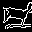
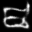

,

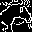
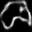

,

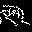
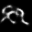

,

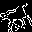
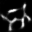

,

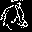
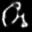

,

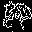
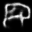

,

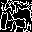
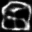

,

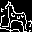
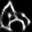

,

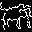
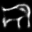

,

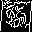
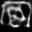

In [24]:
import mediapy
model.eval()
imgs = range(10)
for i in imgs:
    # ae_crit(model.AE(model.F(target_dataset[i][0].unsqueeze(0).cuda())).cpu(), target_dataset[1][0].unsqueeze(0))
    orig = source_dataset[i][0].unsqueeze(0).cuda()
    # orig = uniform_noise(source_dataset[i][0].unsqueeze(0).cuda(), 0.025)
    img = model.AE(model.F(orig))
    # img.max()
    mediapy.show_images([
        orig.cpu().detach().numpy().squeeze(),
        img.cpu().detach().numpy().squeeze()
    ])

# Inference

就跟前幾次作業一樣。這裡我使用pd來生產csv，因為看起來比較潮(?)

此外，200 epochs的Accuracy可能會不太穩定，可以多丟幾次或train久一點。

In [11]:
model = DomainAdapt()
model.load().cuda()

result = []
model.eval()
logits = []
target_dataset.transforms=test_transform
for i, (test_data, _) in enumerate(tqdm(test_dataloader)):
    test_data = test_data.cuda()

    class_logits = model(test_data)
    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    logits.append(class_logits.cpu().detach())
    result.append(x)

import pandas as pd
result = np.concatenate(result)
logits = torch.cat(logits, axis=0)
# Generate your submission
def save_result(result):
    print(np.unique(result, return_counts=True)[1])
    df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
    df.to_csv('DaNN_submission.csv', index=False)

save_result(result)

100%|██████████| 100/100 [00:11<00:00,  8.64it/s]
[ 9762  9148 12338 10024  9533 10286 12810  7726 10623  7750]


## label balance

In [12]:
prob = F.softmax(logits, 1).cpu().numpy()
label = prob.argsort(1)
top2 = np.take_along_axis(prob, label[:, [-1, -2]], 1)
ratio = top2[:, 1]/top2[:, 0]
mask = np.ones((len(label)), dtype=bool)
res = np.zeros((len(label)), dtype=int)
count = np.zeros(n_class, dtype=int)
max_n = len(res)//n_class
for i in range(n_class):
    # i = 1
    m = label[:, -1] == i
    num = int(m.sum())
    idx = ratio[m].argsort()
    sel = np.arange(len(label))[m][idx[:max_n]]
    res[sel] = i
    mask[sel] = False

# sel = ratio[mask] >= 0.5
# idx = np.arange(len(label))[mask]
# res[idx[sel]] = label[idx[sel], -2]
# res[idx[~sel]] = label[idx[~sel], -1]
res[mask] = label[mask, -2]

In [14]:
save_result(res)

[ 9762  9148 12338 10024  9533 10286 12810  7726 10623  7750]


# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

有任何問題 Domain Adaptation 的問題可以寄信到ntu-ml-2021spring-ta@googlegroups.com。

時間允許的話我會更新在這裡。

# Special Thanks
這次的作業其實是我出在 2019FALL 的 ML Final Project，以下是我認為在 Final Report 不錯的幾組，有興趣的話歡迎大家參考看看。

[NTU_r08942071_太神啦 / 組長: 劉正仁同學](https://drive.google.com/open?id=11uNDcz7_eMS8dMQxvnWsbrdguu9k4c-c)

[NTU_r08921a08_CAT / 組長: 廖子毅同學](https://drive.google.com/open?id=1xIkSs8HAShdcfV1E0NEnf4JDbL7POZTf)
